# FMRI Preprocessing Pipeline
Via EEG/FMRI Naturalistic Viewing Dataset (Natview): Resting State

In [20]:
# imports

# connecting to natview dataset
from dotenv import load_dotenv
import os
import glob
from pathlib import Path

# computation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# nilearn and nibabel (neurosci libraries)
import nibabel as nib
from nilearn import datasets
from nilearn import plotting
from nilearn.maskers import NiftiMapsMasker, NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.plotting import find_parcellation_cut_coords

In [3]:
load_dotenv()
DATA_PATH = os.getenv("HPC_NATVIEW_PATH")

In [4]:
# grabbing 22 subjects
rawdata_path = f"{DATA_PATH}/rawdata"
subjects = [f"{rawdata_path}/sub-{i:02d}" for i in range(1, 23)]
test_sub = subjects[0] # subject 01, i.e. 'sub-01'
test_sub

'/Users/maggiezhang/hpc-lab/Projects/Hypergraphsciousness/datasets/natview/rawdata/sub-01'

In [5]:
# relevant paths
schaefer_timeseries = [f"{DATA_PATH}/derivatives/natview_nki_release/sub-{i:02d}/ses-01/func/sub-{i:02d}_ses-01_task-rest_bold/func_atlas/sub-{i:02d}_ses-01_task-rest_space-MNI152Lin_res-3mm_atlas-Schaefer2018_dens-200parcels7networks_desc-sm0_bold.tsv" for i in range(1, 23)]
test_sub_ts = schaefer_timeseries[0]

bold_mni_path = [f"{DATA_PATH}/derivatives/natview_nki_release/sub-{i:02d}/ses-01/func/sub-{i:02d}_ses-01_task-rest_bold/func_preproc/func_pp_nofilt_sm0.mni152.3mm.nii.gz" for i in range(1, 23)]
test_sub_bold_mni = bold_mni_path[0]

## Visualizing Schaefer Atlas

In [6]:
from nilearn import datasets
from nilearn.plotting import plot_roi, plot_stat_map, show

# Schaefer 2018: 200 ROIs, 7 Yeo networks, 2mm (matches typical fMRI)
schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
atlas_img = schaefer.maps
print(f"Atlas: {atlas_img}")

[fetch_atlas_schaefer_2018] Dataset found in /Users/maggiezhang/nilearn_data/schaefer_2018
Atlas: /Users/maggiezhang/nilearn_data/schaefer_2018/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


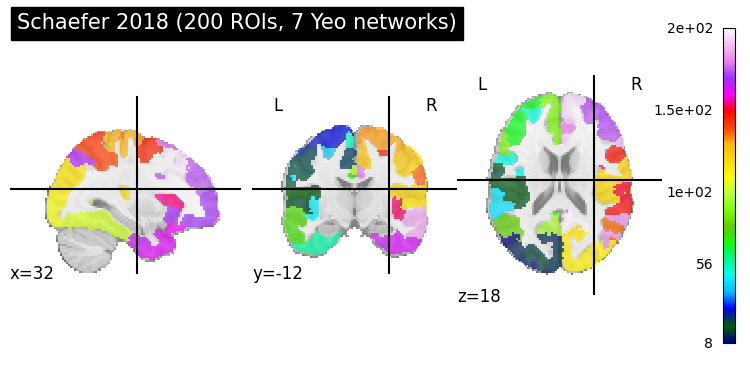

In [7]:
# Plot Schaefer atlas (ROI boundaries)
plot_roi(atlas_img, title="Schaefer 2018 (200 ROIs, 7 Yeo networks)", colorbar=True)
show()

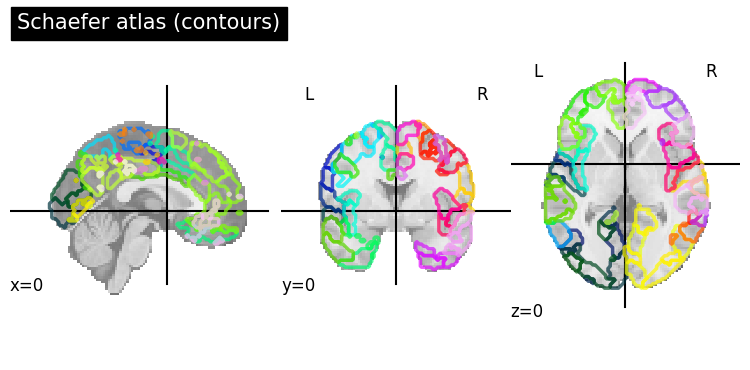

In [8]:
# Plot with contours
plot_roi(atlas_img, view_type="contours", title="Schaefer atlas (contours)")
show()

## Loading Schaefer 2018 TSV with 200 ROI parcellations
For creating correlation matrices.

In [13]:
ts = pd.read_csv(test_sub_ts, sep='\t', header=None)

# file is parcels × timepoints (200 rows × 288 cols), transpose to timepoints × parcels
ts = ts.T
# shape is (288, 200)

# parcel corr mtx 
corr_matrix = ts.corr()
corr_matrix.shape # expect (200, 200)

(200, 200)

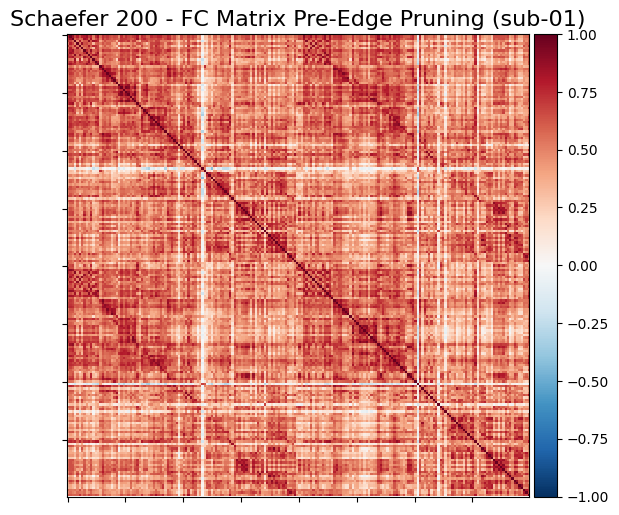

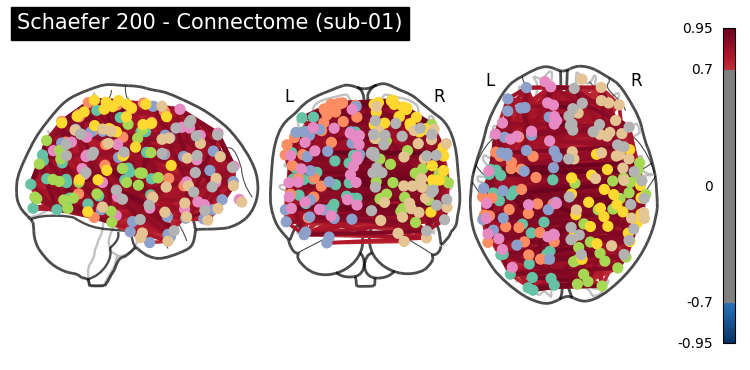

In [14]:
# corr matrix plot (omit labels)
plotting.plot_matrix(
    corr_matrix.values,
    colorbar=True, vmax=1, vmin=-1,
    title="Schaefer 200 - FC Matrix Pre-Edge Pruning (sub-01)"
)

# find ROI center coordinates from the Schaefer atlas image
coords = find_parcellation_cut_coords(labels_img=atlas_img)

# brain connectome(top 10% strongest edges)
plotting.plot_connectome(
    corr_matrix.values,
    coords,
    edge_threshold="90%",
    colorbar=True,
    title="Schaefer 200 - Connectome (sub-01)"
)
plotting.show()

## Loading select subcortical regions
- Thalamus (L/R hemispheres)
- Caudate (L/R hemispheres)
- Putamen (L/R hemispheres)
- Hippocampus (L/R hemispheres)
- Amygdala (L/R hemispheres)

In [15]:
ho_sub = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm')
# harvard-oxford subcortical matches spaces of schaefer, use to grab subcortical fields

print("Harvard-Oxford subcortical labels:")
for i, label in enumerate(ho_sub.labels):
    print(f"  {i:2d}: {label}")

[fetch_atlas_harvard_oxford] Dataset found in /Users/maggiezhang/nilearn_data/fsl
Harvard-Oxford subcortical labels:
   0: Background
   1: Left Cerebral White Matter
   2: Left Cerebral Cortex
   3: Left Lateral Ventricle
   4: Left Thalamus
   5: Left Caudate
   6: Left Putamen
   7: Left Pallidum
   8: Brain-Stem
   9: Left Hippocampus
  10: Left Amygdala
  11: Left Accumbens
  12: Right Cerebral White Matter
  13: Right Cerebral Cortex
  14: Right Lateral Ventricle
  15: Right Thalamus
  16: Right Caudate
  17: Right Putamen
  18: Right Pallidum
  19: Right Hippocampus
  20: Right Amygdala
  21: Right Accumbens


In [16]:
# target regions and corresponding indices
target_regions = ['Left Thalamus', 'Right Thalamus', 'Left Caudate', 'Right Caudate', 'Left Putamen', 'Right Putamen', 'Left Hippocampus',  'Right Hippocampus', 'Left Amygdala', 'Right Amygdala',]
target_indices = []
for region in target_regions:
    idx = ho_sub.labels.index(region)
    target_indices.append(idx)
print(f"\nTarget label indices: {target_indices}")

atlas_nii = ho_sub.maps
atlas_data = atlas_nii.get_fdata().copy()

# zero out non-target voxels
keep_mask = np.isin(atlas_data, target_indices)
atlas_data[~keep_mask] = 0
subcortical_atlas = nib.Nifti1Image(atlas_data, atlas_nii.affine, atlas_nii.header)

# get subcortical timeseries from MNI-space preprocessed BOLD
masker = NiftiLabelsMasker(labels_img=subcortical_atlas, standardize='zscore_sample', resampling_target='data')  # resample atlas to BOLD 3mm resolution
subcortical_ts = masker.fit_transform(test_sub_bold_mni) # test sub

# mapping extracted columns back to region names
extracted_labels = masker.labels_
subcortical_names = [ho_sub.labels[int(l)] for l in extracted_labels]
print(f"\nSubcortical timeseries shape: {subcortical_ts.shape}")  # (288, 10)
print(f"Extracted regions: {subcortical_names}")

# combine with Schaefer cortical timeseries
# ts is the (288, 200) cortical timeseries from earlier
combined_ts = np.hstack([ts.values, subcortical_ts])  # (288, 210)
combined_labels = list(ts.columns) + subcortical_names
print(f"\nCombined timeseries shape: {combined_ts.shape}")  # (288, 210)

# combined correlation matrix
combined_corr = np.corrcoef(combined_ts, rowvar=False)  # (210, 210)
print(f"Combined correlation matrix shape: {combined_corr.shape}")


Target label indices: [4, 15, 5, 16, 6, 17, 9, 19, 10, 20]

Subcortical timeseries shape: (288, 10)
Extracted regions: ['Background', 'Left Thalamus', 'Left Caudate', 'Left Putamen', 'Left Hippocampus', 'Left Amygdala', 'Right Thalamus', 'Right Caudate', 'Right Putamen', 'Right Hippocampus', 'Right Amygdala']

Combined timeseries shape: (288, 210)
Combined correlation matrix shape: (210, 210)


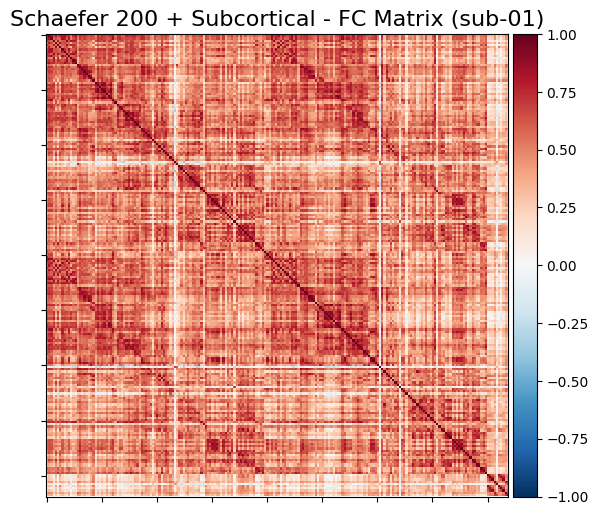

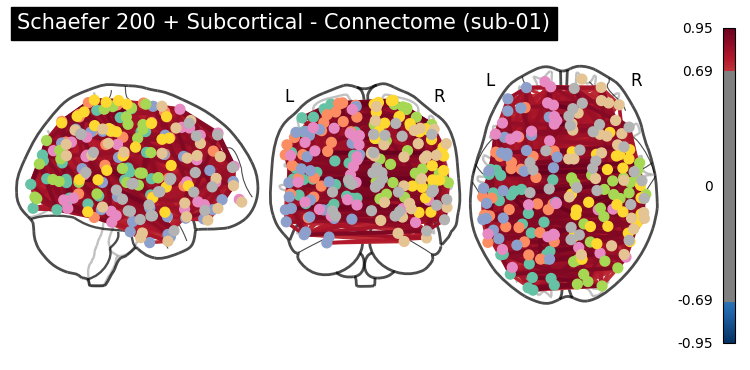

In [63]:
# combined FC matrix (200 cortical + 10 subcortical = 210 ROIs)
plotting.plot_matrix(
    combined_corr,
    colorbar=True, vmax=1, vmin=-1,
    title="Schaefer 200 + Subcortical - FC Matrix (sub-01)"
)

# compute coords: schaefer cortical + subcortical centers
cortical_coords = find_parcellation_cut_coords(labels_img=atlas_img)
subcortical_coords = find_parcellation_cut_coords(labels_img=subcortical_atlas)
combined_coords = np.vstack([cortical_coords, subcortical_coords])

# brain connectome (top 10% strongest edges)
plotting.plot_connectome(
    combined_corr,
    combined_coords,
    edge_threshold="90%",
    colorbar=True,
    title="Schaefer 200 + Subcortical - Connectome (sub-01)"
)
plotting.show()

## Saving Combined Correlation Matrices for All Subjects
Save Schaefer 200 cortical + 10 subcortical (210 × 210) correlation matrices per subject.

In [66]:
# output directory (project root: KD_fMRI_EEG_Omics/sample_data/)
output_dir = "../../sample_data/corr_matrices"
os.makedirs(output_dir, exist_ok=True)

# cortical ROI names from schaefer atlas
cortical_names = [label.decode() if isinstance(label, bytes) else str(label) for label in schaefer.labels[1:]]

# combined ROI labels: 200 cortical + 10 subcortical
all_roi_names = cortical_names + target_regions
np.save(f"{output_dir}/roi_labels.npy", np.array(all_roi_names))
print(f"Saved roi_labels.npy ({len(all_roi_names)} ROIs)")

# reusable masker for subcortical extraction
sub_masker = NiftiLabelsMasker(
    labels_img=subcortical_atlas,
    standardize='zscore_sample',
    resampling_target='data',
)

# process all 22 subjects
for i in range(len(schaefer_timeseries)):
    sub_id = f"sub-{i+1:02d}"
    print(f"Processing {sub_id}...", end=" ")

    # cortical timeseries from schaefer TSV
    cortical_ts = pd.read_csv(schaefer_timeseries[i], sep='\t', header=None).T  # (288, 200)

    # subcortical timeseries from MNI-space preprocessed BOLD
    subcortical_ts = sub_masker.fit_transform(bold_mni_path[i])  # (288, 10)

    # combine cortical + subcortical
    combined_ts = np.hstack([cortical_ts.values, subcortical_ts])  # (288, 210)

    # full-scan correlation matrix
    combined_corr = np.corrcoef(combined_ts, rowvar=False)  # (210, 210)

    # save
    save_path = f"{output_dir}/{sub_id}_combined_corr.npy"
    np.save(save_path, combined_corr)
    print(f"saved {combined_corr.shape}")

print(f"\nDone! {len(schaefer_timeseries)} correlation matrices saved to {output_dir}/")

Saved roi_labels.npy (210 ROIs)
Processing sub-01... saved (210, 210)
Processing sub-02... saved (210, 210)
Processing sub-03... saved (210, 210)
Processing sub-04... saved (210, 210)
Processing sub-05... saved (210, 210)
Processing sub-06... saved (210, 210)
Processing sub-07... saved (210, 210)
Processing sub-08... saved (210, 210)
Processing sub-09... saved (210, 210)
Processing sub-10... saved (210, 210)
Processing sub-11... saved (210, 210)
Processing sub-12... saved (210, 210)
Processing sub-13... saved (210, 210)
Processing sub-14... saved (210, 210)
Processing sub-15... saved (210, 210)
Processing sub-16... saved (210, 210)
Processing sub-17... saved (210, 210)
Processing sub-18... saved (210, 210)
Processing sub-19... saved (210, 210)
Processing sub-20... saved (210, 210)
Processing sub-21... saved (210, 210)
Processing sub-22... saved (210, 210)

Done! 22 correlation matrices saved to ../../sample_data/corr_matrices/


ROI labels shape: (211,)

--- All 211 ROI labels ---
    0: Background
    1: 7Networks_LH_Vis_1
    2: 7Networks_LH_Vis_2
    3: 7Networks_LH_Vis_3
    4: 7Networks_LH_Vis_4
    5: 7Networks_LH_Vis_5
    6: 7Networks_LH_Vis_6
    7: 7Networks_LH_Vis_7
    8: 7Networks_LH_Vis_8
    9: 7Networks_LH_Vis_9
   10: 7Networks_LH_Vis_10
   11: 7Networks_LH_Vis_11
   12: 7Networks_LH_Vis_12
   13: 7Networks_LH_Vis_13
   14: 7Networks_LH_Vis_14
   15: 7Networks_LH_SomMot_1
   16: 7Networks_LH_SomMot_2
   17: 7Networks_LH_SomMot_3
   18: 7Networks_LH_SomMot_4
   19: 7Networks_LH_SomMot_5
   20: 7Networks_LH_SomMot_6
   21: 7Networks_LH_SomMot_7
   22: 7Networks_LH_SomMot_8
   23: 7Networks_LH_SomMot_9
   24: 7Networks_LH_SomMot_10
   25: 7Networks_LH_SomMot_11
   26: 7Networks_LH_SomMot_12
   27: 7Networks_LH_SomMot_13
   28: 7Networks_LH_SomMot_14
   29: 7Networks_LH_SomMot_15
   30: 7Networks_LH_SomMot_16
   31: 7Networks_LH_DorsAttn_Post_1
   32: 7Networks_LH_DorsAttn_Post_2
   33: 7Networks_

/Users/maggiezhang/CS274C/KD_fMRI_EEG_Omics/venv/lib/python3.11/site-packages/nilearn/plotting/matrix/matrix_plotting.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(


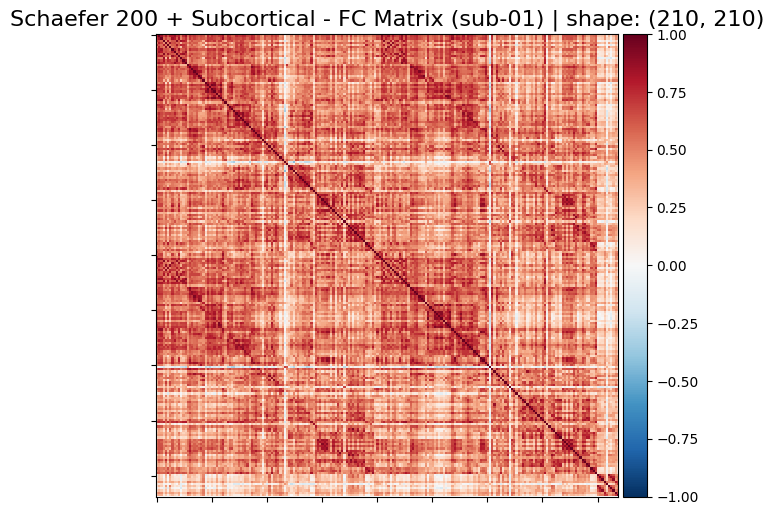

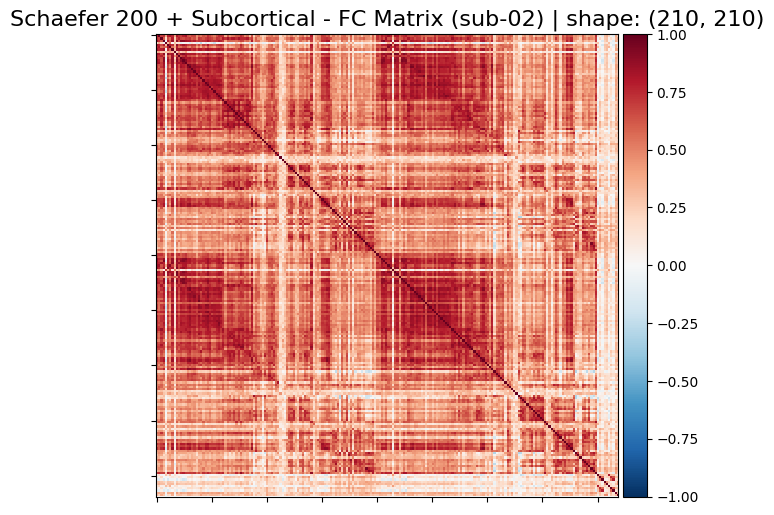

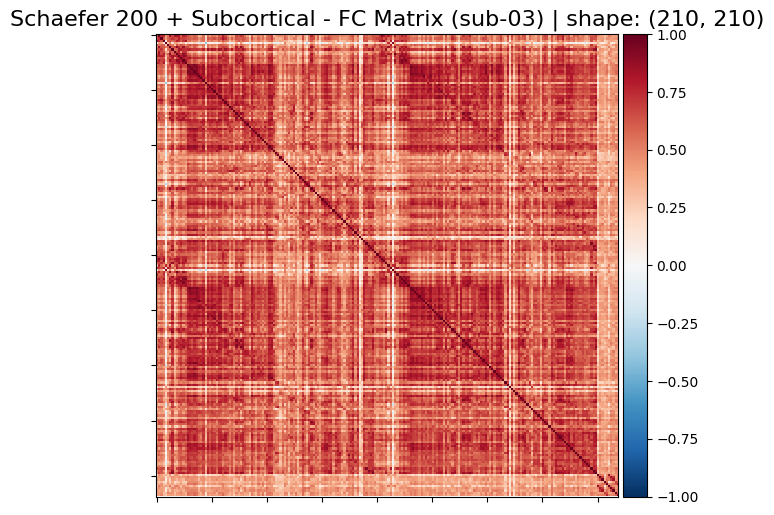

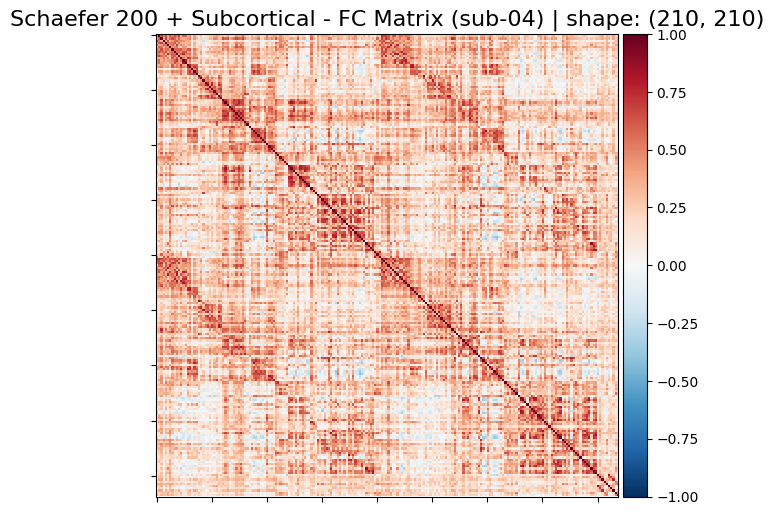

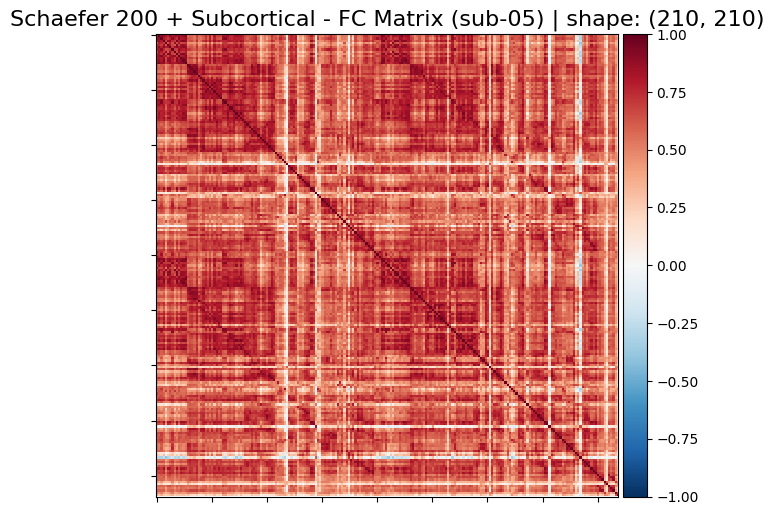

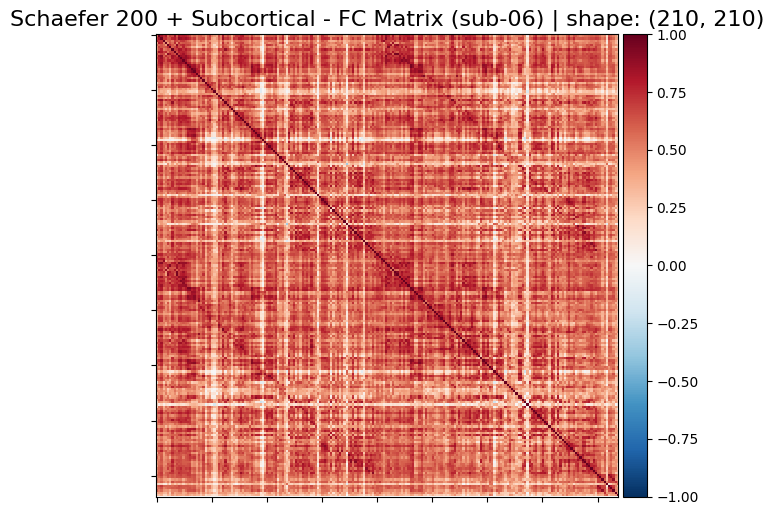

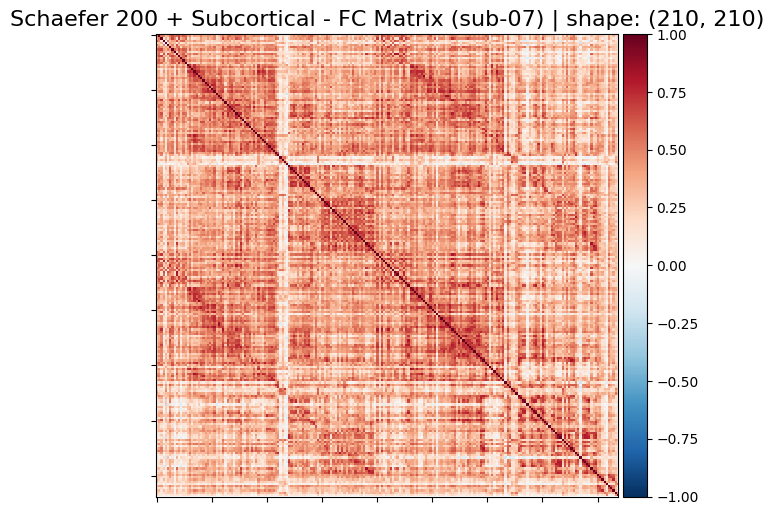

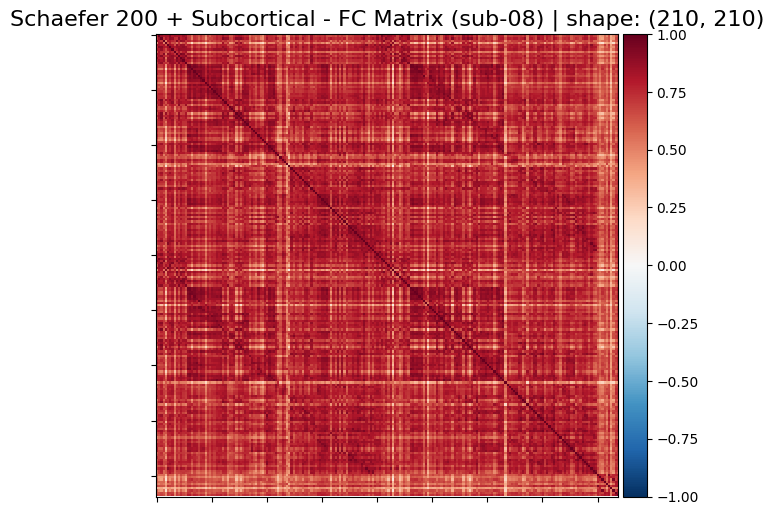

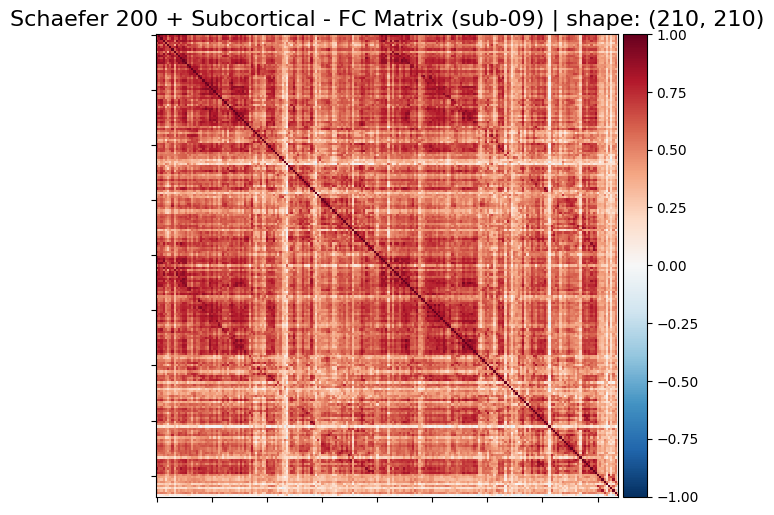

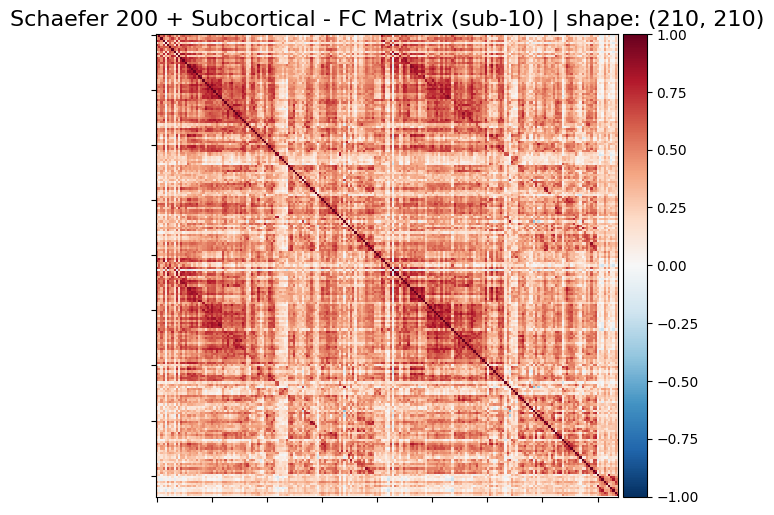

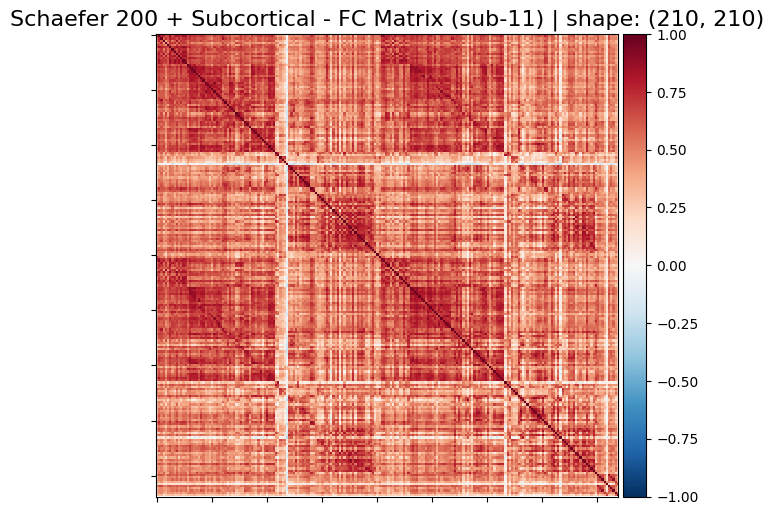

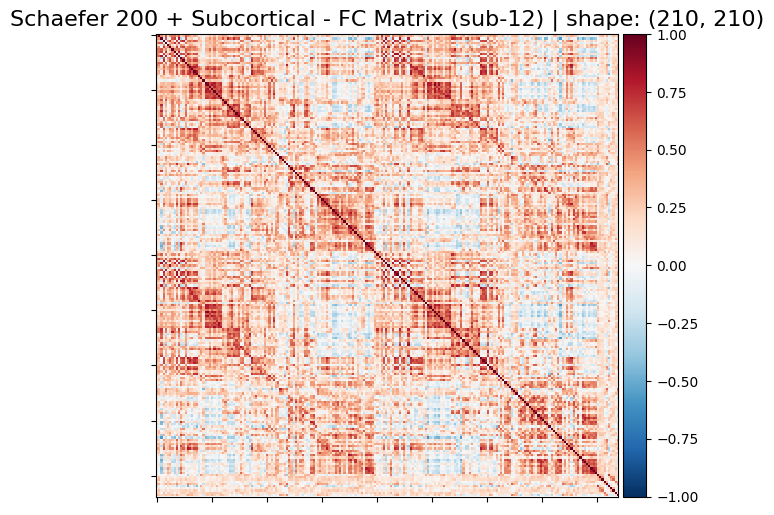

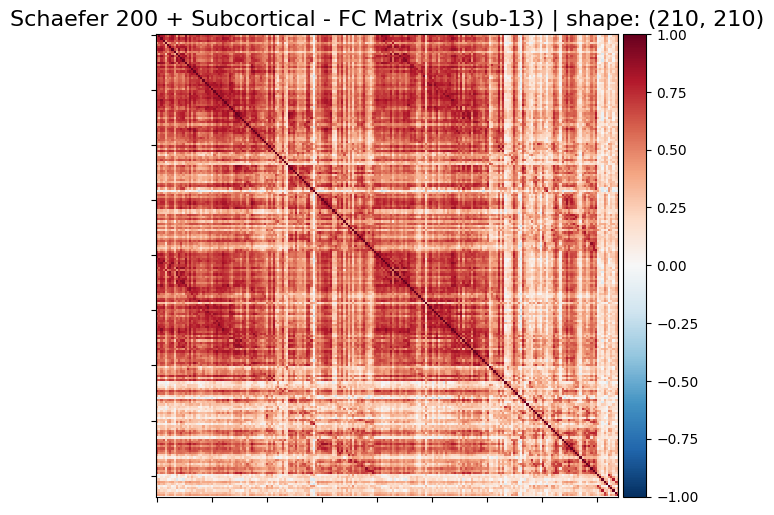

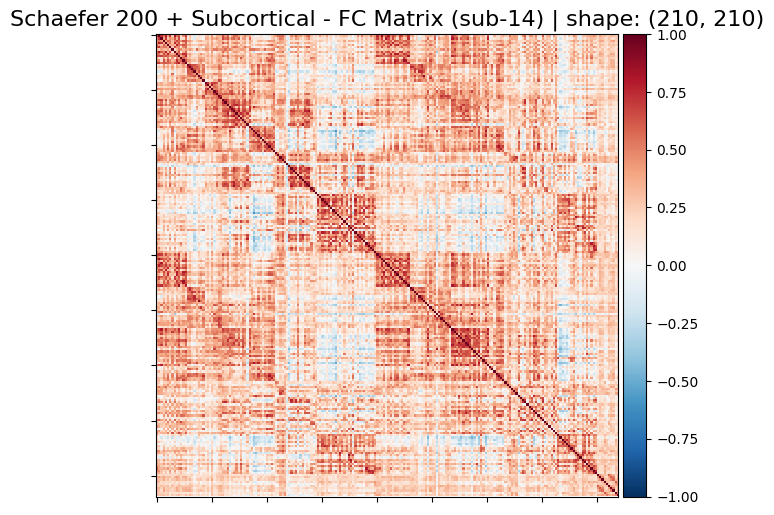

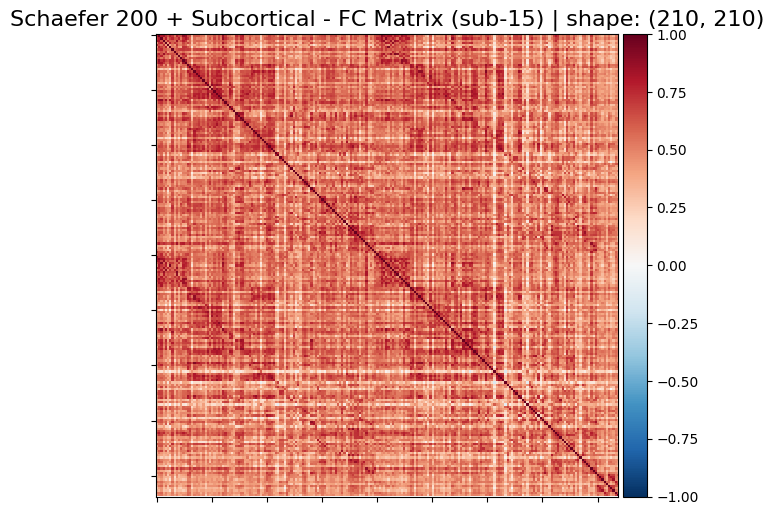

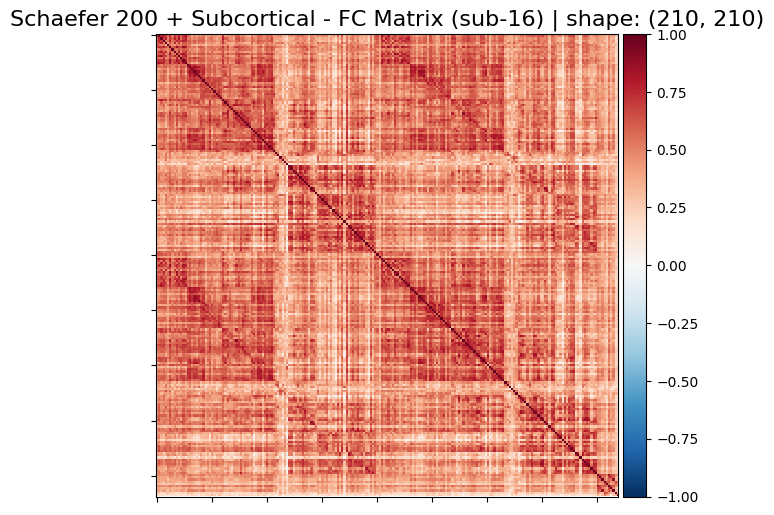

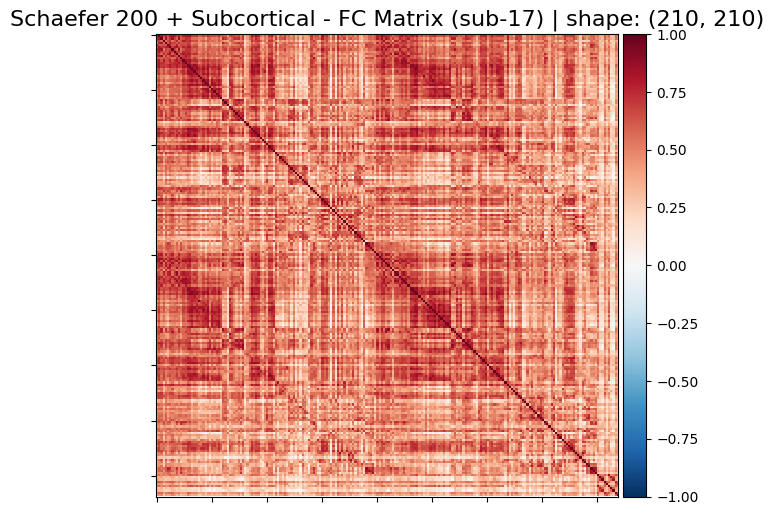

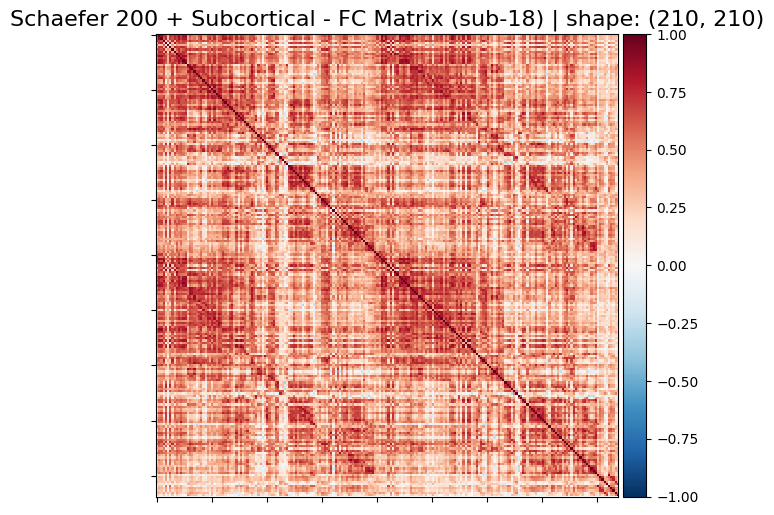

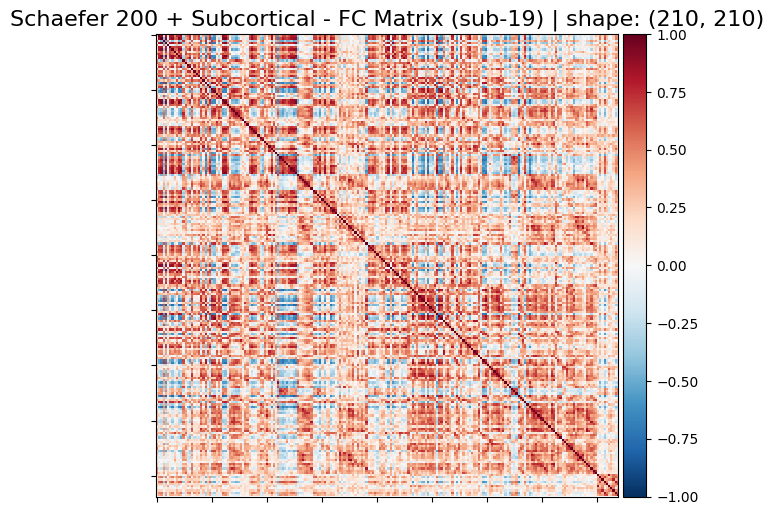

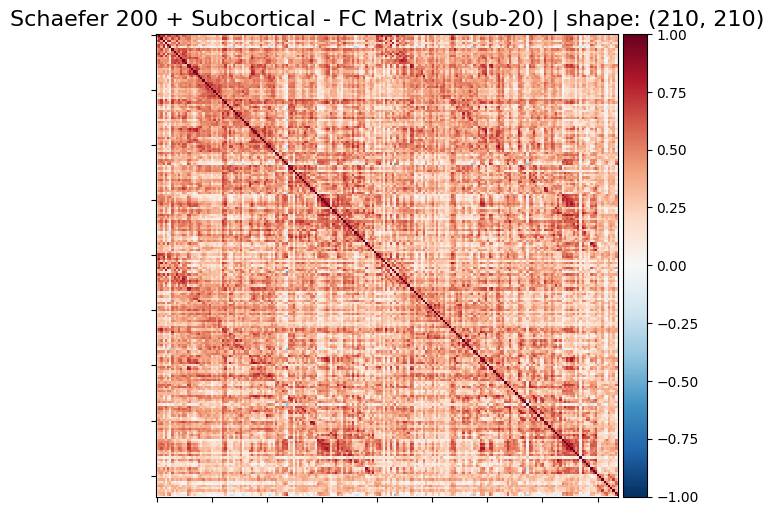

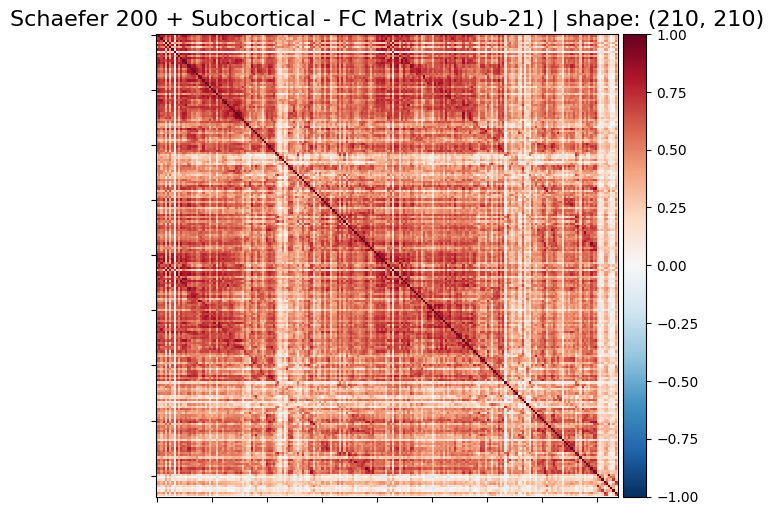

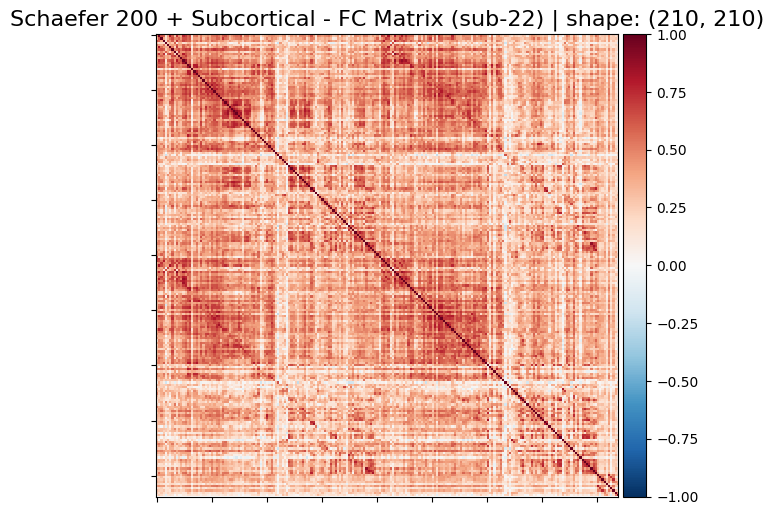

In [65]:
# load and print saved ROI labels
output_dir = "../../sample_data/corr_matrices"
roi_labels = np.load(f"{output_dir}/roi_labels.npy", allow_pickle=True)
print(f"ROI labels shape: {roi_labels.shape}")
print(f"\n--- All {len(roi_labels)} ROI labels ---")
for i, label in enumerate(roi_labels):
    print(f"  {i:3d}: {label}")

# plot each subject's saved correlation matrix
for i in range(1, 23):
    sub_id = f"sub-{i:02d}"
    corr = np.load(f"{output_dir}/{sub_id}_combined_corr.npy")
    plotting.plot_matrix(
        corr,
        colorbar=True, vmax=1, vmin=-1,
        title=f"Schaefer 200 + Subcortical - FC Matrix ({sub_id}) | shape: {corr.shape}"
    )
plotting.show()

In [9]:
# save corr matrix images
import matplotlib.pyplot as plt

output_dir = "../../sample_data/corr_matrices"
img_dir = f"{output_dir}/images"
os.makedirs(img_dir, exist_ok=True)

for i in range(1, 23):
    sub_id = f"sub-{i:02d}"
    corr = np.load(f"{output_dir}/{sub_id}_combined_corr.npy")

    fig = plotting.plot_matrix(
        corr,
        colorbar=True, vmax=1, vmin=-1,
        title=f"Schaefer 200 + Subcortical - FC Matrix ({sub_id})"
    )
    fig.figure.savefig(f"{img_dir}/{sub_id}_fc_matrix.png", dpi=150, bbox_inches='tight')
    plt.close(fig.figure)
    print(f"Saved {sub_id}_fc_matrix.png")

print(f"\nDone! 22 images saved to {img_dir}/")

Saved sub-01_fc_matrix.png
Saved sub-02_fc_matrix.png
Saved sub-03_fc_matrix.png
Saved sub-04_fc_matrix.png
Saved sub-05_fc_matrix.png
Saved sub-06_fc_matrix.png
Saved sub-07_fc_matrix.png
Saved sub-08_fc_matrix.png
Saved sub-09_fc_matrix.png
Saved sub-10_fc_matrix.png
Saved sub-11_fc_matrix.png
Saved sub-12_fc_matrix.png
Saved sub-13_fc_matrix.png
Saved sub-14_fc_matrix.png
Saved sub-15_fc_matrix.png
Saved sub-16_fc_matrix.png
Saved sub-17_fc_matrix.png
Saved sub-18_fc_matrix.png
Saved sub-19_fc_matrix.png
Saved sub-20_fc_matrix.png
Saved sub-21_fc_matrix.png
Saved sub-22_fc_matrix.png

Done! 22 images saved to ../../sample_data/corr_matrices/images/


## Interval-based FC correlation matrix construction
Using patches from EEG-derived vigilance labels (ses-01 only).

In [22]:
# output directory for interval-based corr matrices
interval_dir = "../../sample_data/28TR_interval_corr_matrices"
os.makedirs(interval_dir, exist_ok=True)

# path to EEG-derived patches (ses-01 only, 22 subjects)
eeg_dir = "../../sample_data/eeg_28TR_interval_labels"

In [23]:
# inspect sample patches file
sample_patches = pd.read_csv(f"{eeg_dir}/sub-01_ses-01_task-rest_vigilance_patches.tsv", sep='\t')
print(f"Patches shape: {sample_patches.shape}")
print(f"Columns: {list(sample_patches.columns)}")
print(f"\nFirst 5 patches:")
sample_patches.head()

Patches shape: (10, 7)
Columns: ['patch_index', 'start_tr', 'end_tr', 't_start_s', 't_end_s', 'window_sum', 'label_binary']

First 5 patches:


patch_index  start_tr  end_tr  t_start_s  t_end_s  window_sum  label_binary
0            0         0      28        0.0     58.8           1             1
1            1        28      56       58.8    117.6          13             1
2            2        56      84      117.6    176.4           1             1
3            3        84     112      176.4    235.2          -8             0
4            4       112     140      235.2    294.0         -12             0

In [25]:
# reusable masker for subcortical extraction
sub_masker = NiftiLabelsMasker(
    labels_img=subcortical_atlas,
    standardize='zscore_sample',
    resampling_target='data',
)

# process all 22 subjects (ses-01 only)
for i in range(len(schaefer_timeseries)):
    sub_id = f"sub-{i+1:02d}"
    patches_file = f"{eeg_dir}/{sub_id}_ses-01_task-rest_vigilance_patches.tsv"


    if not os.path.exists(patches_file):
        print(f"SKIP {sub_id}: no ses-01 patches file")
        continue

    print(f"Processing {sub_id}...", end=" ")

    # load patches TSV
    patches = pd.read_csv(patches_file, sep='\t')
    n_patches = len(patches)

    # reconstruct combined timeseries (cortical + subcortical)
    cortical_ts = pd.read_csv(schaefer_timeseries[i], sep='\t', header=None).T  # (288, 200)
    subcortical_ts = sub_masker.fit_transform(bold_mni_path[i])  # (288, 10)
    combined_ts = np.hstack([cortical_ts.values, subcortical_ts])  # (288, 210)

    # compute per-patch correlation matrices
    patch_corrs = np.zeros((n_patches, 210, 210))
    labels = np.zeros(n_patches, dtype=int)

    for p_idx, row in patches.iterrows():
        start_tr = int(row['start_tr'])
        end_tr = int(row['end_tr'])
        patch_ts = combined_ts[start_tr:end_tr, :]  # (28, 210)
        patch_corrs[p_idx] = np.corrcoef(patch_ts, rowvar=False)  # (210, 210)
        labels[p_idx] = int(row['label_binary'])

    # save
    np.save(f"{interval_dir}/{sub_id}_interval_corr.npy", patch_corrs)
    np.save(f"{interval_dir}/{sub_id}_labels.npy", labels)

    n_alert = np.sum(labels == 1)
    n_drowsy = np.sum(labels == 0)
    print(f"{n_patches} patches | alert: {n_alert}, drowsy: {n_drowsy}")

print(f"\nDone! Saved to {interval_dir}/")

Processing sub-01... 10 patches | alert: 5, drowsy: 5
Processing sub-02... 11 patches | alert: 7, drowsy: 4
Processing sub-03... 11 patches | alert: 8, drowsy: 3
Processing sub-04... 11 patches | alert: 5, drowsy: 6
Processing sub-05... 11 patches | alert: 5, drowsy: 6
Processing sub-06... 10 patches | alert: 6, drowsy: 4
Processing sub-07... 

/Users/maggiezhang/CS274C/KD_fMRI_EEG_Omics/venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:576: RuntimeWarning: Mean of empty slice
  avg = a.mean(axis, **keepdims_kw)
/Users/maggiezhang/CS274C/KD_fMRI_EEG_Omics/venv/lib/python3.11/site-packages/numpy/_core/_methods.py:134: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/maggiezhang/CS274C/KD_fMRI_EEG_Omics/venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3015: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/maggiezhang/CS274C/KD_fMRI_EEG_Omics/venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2888: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/maggiezhang/CS274C/KD_fMRI_EEG_Omics/venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2888: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


16 patches | alert: 8, drowsy: 8
Processing sub-08... 11 patches | alert: 9, drowsy: 2
Processing sub-09... 10 patches | alert: 4, drowsy: 6
Processing sub-10... 11 patches | alert: 7, drowsy: 4
Processing sub-11... 10 patches | alert: 6, drowsy: 4
Processing sub-12... 10 patches | alert: 5, drowsy: 5
Processing sub-13... 10 patches | alert: 6, drowsy: 4
Processing sub-14... 10 patches | alert: 5, drowsy: 5
Processing sub-15... 11 patches | alert: 7, drowsy: 4
Processing sub-16... 10 patches | alert: 6, drowsy: 4
Processing sub-17... 10 patches | alert: 6, drowsy: 4
Processing sub-18... 10 patches | alert: 7, drowsy: 3
Processing sub-19... 11 patches | alert: 7, drowsy: 4
Processing sub-20... 11 patches | alert: 6, drowsy: 5
Processing sub-21... 10 patches | alert: 5, drowsy: 5
Processing sub-22... 10 patches | alert: 5, drowsy: 5

Done! Saved to ../../sample_data/28TR_interval_corr_matrices/


In [27]:
# verify saved interval corr matrices
for i in range(1, 23):
    sub_id = f"sub-{i:02d}"
    corr_path = f"{interval_dir}/{sub_id}_interval_corr.npy"
    label_path = f"{interval_dir}/{sub_id}_labels.npy"

    if not os.path.exists(corr_path):
        print(f"{sub_id}: not found")
        continue

    corrs = np.load(corr_path)
    labels = np.load(label_path)
    print(f"{sub_id}: corr {corrs.shape}, labels {labels.shape} | alert: {np.sum(labels==1)}, drowsy: {np.sum(labels==0)}")

sub-01: corr (10, 210, 210), labels (10,) | alert: 5, drowsy: 5
sub-02: corr (11, 210, 210), labels (11,) | alert: 7, drowsy: 4
sub-03: corr (11, 210, 210), labels (11,) | alert: 8, drowsy: 3
sub-04: corr (11, 210, 210), labels (11,) | alert: 5, drowsy: 6
sub-05: corr (11, 210, 210), labels (11,) | alert: 5, drowsy: 6
sub-06: corr (10, 210, 210), labels (10,) | alert: 6, drowsy: 4
sub-07: corr (16, 210, 210), labels (16,) | alert: 8, drowsy: 8
sub-08: corr (11, 210, 210), labels (11,) | alert: 9, drowsy: 2
sub-09: corr (10, 210, 210), labels (10,) | alert: 4, drowsy: 6
sub-10: corr (11, 210, 210), labels (11,) | alert: 7, drowsy: 4
sub-11: corr (10, 210, 210), labels (10,) | alert: 6, drowsy: 4
sub-12: corr (10, 210, 210), labels (10,) | alert: 5, drowsy: 5
sub-13: corr (10, 210, 210), labels (10,) | alert: 6, drowsy: 4
sub-14: corr (10, 210, 210), labels (10,) | alert: 5, drowsy: 5
sub-15: corr (11, 210, 210), labels (11,) | alert: 7, drowsy: 4
sub-16: corr (10, 210, 210), labels (10,

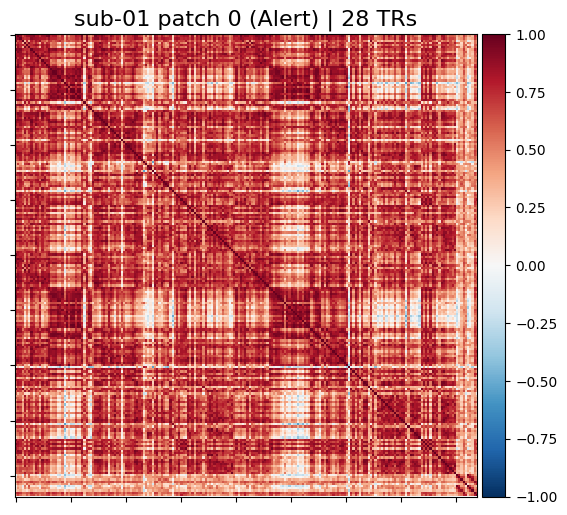

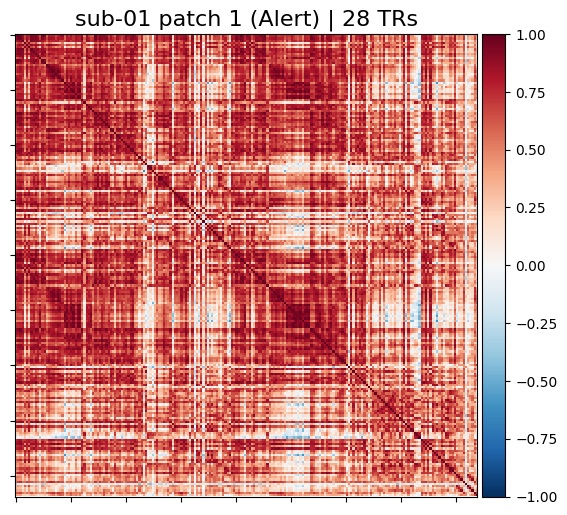

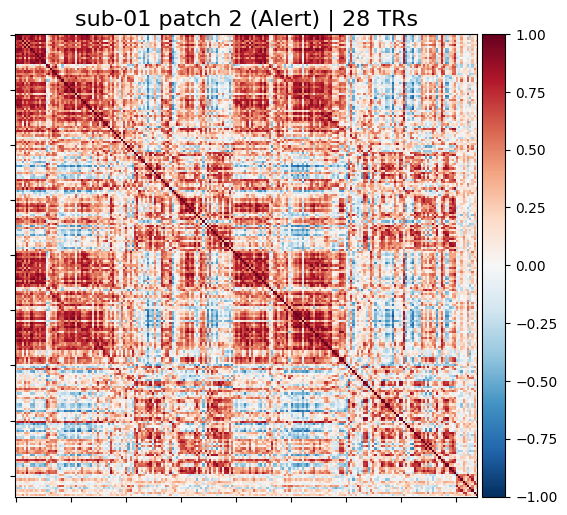

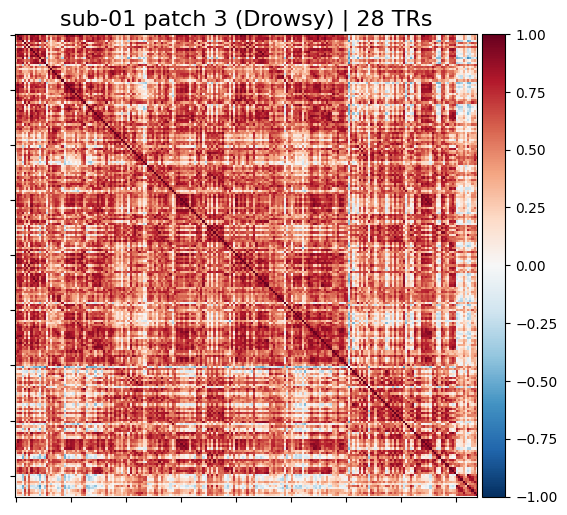

In [37]:
# plot sample interval corr matrices (sub-01, first 4 patches)

sub01_corrs = np.load(f"{interval_dir}/sub-01_interval_corr.npy")
sub01_labels = np.load(f"{interval_dir}/sub-01_labels.npy")

for p in range(4):
    label_str = "Alert" if sub01_labels[p] == 1 else "Drowsy"
    plotting.plot_matrix(
        sub01_corrs[p],
        colorbar=True, vmax=1, vmin=-1,
        title=f"sub-01 patch {p} ({label_str}) | 28 TRs"
    )
plotting.show()

In [31]:
# save all interval corr matrix plots
import matplotlib.pyplot as plt

img_dir = f"{interval_dir}/images"
os.makedirs(img_dir, exist_ok=True)

for i in range(1, 23):
    sub_id = f"sub-{i:02d}"
    corr_path = f"{interval_dir}/{sub_id}_interval_corr.npy"
    label_path = f"{interval_dir}/{sub_id}_labels.npy"

    if not os.path.exists(corr_path):
        print(f"SKIP {sub_id}: not found")
        continue

    corrs = np.load(corr_path)
    labels = np.load(label_path)

    for p in range(len(labels)):
        label_str = "alert" if labels[p] == 1 else "drowsy"
        fig = plotting.plot_matrix(
            corrs[p],
            colorbar=True, vmax=1, vmin=-1,
            title=f"{sub_id} patch {p} ({label_str}) | 28 TRs"
        )
        fig.figure.savefig(f"{img_dir}/{sub_id}_patch{p:02d}_{label_str}.png", dpi=150, bbox_inches='tight')
        plt.close(fig.figure)

    print(f"Saved {len(labels)} plots for {sub_id}")

print(f"\nDone! All interval plots saved to {img_dir}/")

Saved 10 plots for sub-01
Saved 11 plots for sub-02
Saved 11 plots for sub-03
Saved 11 plots for sub-04
Saved 11 plots for sub-05
Saved 10 plots for sub-06
Saved 16 plots for sub-07
Saved 11 plots for sub-08
Saved 10 plots for sub-09
Saved 11 plots for sub-10
Saved 10 plots for sub-11
Saved 10 plots for sub-12
Saved 10 plots for sub-13
Saved 10 plots for sub-14
Saved 11 plots for sub-15
Saved 10 plots for sub-16
Saved 10 plots for sub-17
Saved 10 plots for sub-18
Saved 11 plots for sub-19
Saved 11 plots for sub-20
Saved 10 plots for sub-21
Saved 10 plots for sub-22

Done! All interval plots saved to ../../sample_data/28TR_interval_corr_matrices/images/
